# Part 3: Transfer Learning

Based on the last notebook, in this notebook a method is used to solve the overfitting problem that was introduced in the multiclass classification.

### Importing Libraries and Data

In [1]:
import os

import torch
import torchvision
import sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchinfo import summary
from training import train, predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Available device: {device}")

Available device: cpu


In [3]:
data_dir = os.path.join("../data/plant disease/Cassava/", "undersampled")
data_dir

'../data/plant disease/Cassava/undersampled'

In [4]:
norm_transformation = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.4776, 0.5616, 0.4120], std = [0.2078, 0.1952, 0.2577])
    ]
)

In [5]:
data = datasets.ImageFolder(data_dir, norm_transformation)
data

Dataset ImageFolder
    Number of datapoints: 5075
    Root location: ../data/plant disease/Cassava/undersampled
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.4776, 0.5616, 0.412], std=[0.2078, 0.1952, 0.2577])
           )

In [6]:
classes = data.classes
classes

['Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava green mite',
 'Cassava healthy',
 'Cassava mosaic']

In [7]:
dataloader = DataLoader(data, batch_size= 32)
one_batch_shape = next(iter(dataloader))[0].shape

print(f"Shape of one batch of image data: {one_batch_shape}")
print(type(dataloader))

Shape of one batch of image data: torch.Size([32, 3, 224, 224])
<class 'torch.utils.data.dataloader.DataLoader'>


In [8]:
# Labels of the first batch of the images
next(iter(dataloader))[1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

Now the data is ready. Let's use transfer learning in which an already pretrained model is taken and the last layer is changed and trained for the specific task (predicting crop disease or crop is healthy).

### Transfer Learning

Among the pretrained models publicly available, let's pick one.

In [9]:
model = torchvision.models.resnet50(weights= torchvision.models.ResNet50_Weights.DEFAULT)

summary(model, one_batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

The model has more than 25 million parameters. However we don't train the model. Update the model in which the parameters would not be changed by backpropagation.

In [10]:
for params in model.parameters():
    params.requires_grad = False

Now, let's check the model output shape.

In [11]:
model.to(device)
one_batch = next(iter(dataloader))[0]
test_out = model(one_batch)

print(f"Shape of model output: {test_out.shape}")

Shape of model output: torch.Size([32, 1000])


The output is not as we want (1000 classes instead of 5). So we need to change this last layer to meet to the number of classes.

### Modifying the Network

Instead of training the whole network, we will change the last layer with new one which will does the final classification. The remaining of the network will do the image processing, and provide the new layer with good inputs. This process is called $transfer$ $learning$.

First let's see the last layer.

In [12]:
list(model.named_modules())[-1]

('fc', Linear(in_features=2048, out_features=1000, bias=True))

In [13]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

Now, we build a network to replace this last layer. It will take the same inputs numbers, but different output size.

In [14]:
classfier = torch.nn.Sequential()

class_layer = torch.nn.Linear(
    in_features= 2048, out_features= 256
)
classfier.append(class_layer)

classfier.append(torch.nn.ReLU())
classfier.append(torch.nn.Dropout())

output_layer = torch.nn.Linear(
    in_features= 256, out_features= 5
)
classfier.append(output_layer)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

In [15]:
model.fc = classfier

In [16]:
summary(model, one_batch_shape)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 5]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [17]:
new_test_out = model(one_batch)
print(f"Shape of the output of the new model: {new_test_out.shape}")

Shape of the output of the new model: torch.Size([32, 5])


The model output matches the number of classes. The next step is to train the last two linear layers of the model. It is ok to use the previous train-validation-set split method to train the model on the data. But in this notebook let's try different technique to train our model which will help us in the case of overfitting.

### K-Fold Cross-Validation
The data is split into k-folds, k-1 portion of the data is used for training and the remaining is used for validation. Then reset the model and get the next training and validation sets and repeat until each fold is utilized for validation. For now, we use 5 folds to get each fold to be 20% of the data.

In [18]:
k = 5
kfold_splitter = sklearn.model_selection.KFold(n_splits= k, shuffle= True, random_state= 42)

In [19]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Each time valiation set is changed, the model must be reset. We only need to reset the last two linear layers we added. First let's identify these layers and define a function to reset these layers.

In [20]:
model.fc

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
)

In [21]:
def reset_model(model):
    model.fc.get_submodule("0").reset_parameters()
    model.fc.get_submodule("3").reset_parameters()

As can be seen in the previous notebook, the validation loss starts to increase after sixth epoch. So we train the model for 6 epochs.

Training the model would took more than 2 hours. Here I saved it and let's load it what already trained.

### Model Performance

Training the model gives model performance parameters: training losses, training accuracies, validation losses and validation accuracies. Let's examine the trend of these parameters with respect to epochs.

In [22]:
model = torch.load("../model/project_2/resnet_k_folds", weights_only=False)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
with open("training_records.pkl", "rb") as file:
    train_records = pickle.load(file)

train_records.keys()

dict_keys([1, 2, 3, 4, 5])

In [24]:
train_records.keys()

dict_keys([1, 2, 3, 4, 5])

In [25]:
train_records[1].keys()

dict_keys(['training losses', 'validation losses', 'validation accuracy'])

In [26]:
def plot_params(data, param):
    for fold in data.keys():
        plt.plot(data[fold][param], label= f"Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel(param)
    plt.legend()

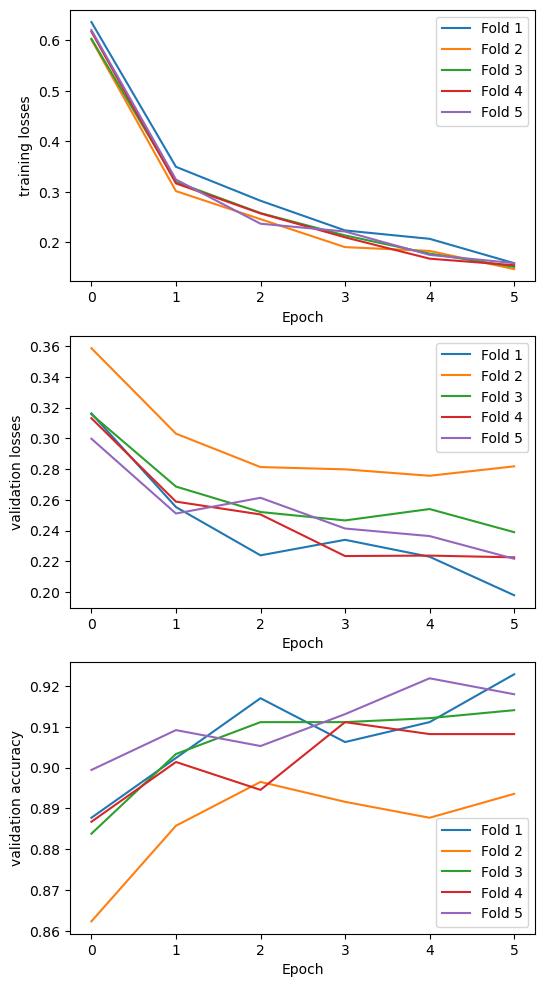

In [27]:
plt.figure(figsize= (6, 12))

plt.subplot(3, 1, 1)
plot_params(train_records, "training losses")

plt.subplot(3, 1, 2)
plot_params(train_records, "validation losses")

plt.subplot(3, 1, 3)
plot_params(train_records, "validation accuracy")

plt.show()

In the valdation losses and accuracies, there are variations and even getting worse in some fold numbers. This suggests that the model is reaching to overfitting.

Instead of seeing individual folds, it is better to calculate the average of all folds for the last epoch for each metrics.

In [28]:
for metric in train_records[1].keys():
    metric_avg = np.mean(
        [train_records[fold][metric][-1] for fold in train_records.keys()]
    )
    print(f"Average of {metric}: {metric_avg:.3f}")

Average of training losses: 0.154
Average of validation losses: 0.233
Average of validation accuracy: 0.911


These values indicate that the model generalizes better on the validation set than before due to the application of k-fold cross validation.

Let's examine the confusion matrix. The _val_loader_ variable should be the validation set for the last fold.

In [29]:
tra_idx, val_idx = list(kfold_splitter.split(np.arange(len(data))))[-1]
val_data = torch.utils.data.Subset(data, val_idx)
val_loader = DataLoader(val_data, batch_size= 32)

In [30]:
probs = predict(model, val_loader, device= device)
preds = torch.argmax(probs, dim= 1)
preds

Predicting:   0%|          | 0/32 [00:00<?, ?it/s]

tensor([0, 0, 1,  ..., 4, 4, 4])

In [31]:
trgs = []
for _, labels in tqdm(val_loader):
    trgs.extend(labels.tolist())
trgs[:10]

100%|██████████| 32/32 [00:08<00:00,  3.91it/s]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

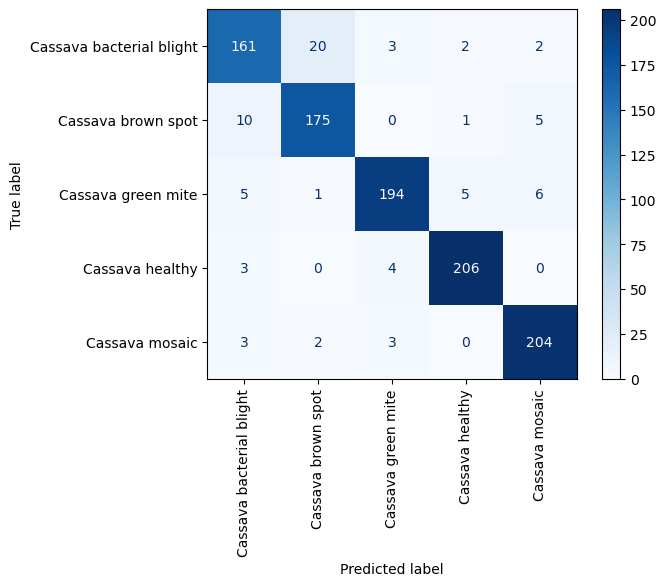

In [32]:
conf_mat = confusion_matrix(trgs, preds.tolist())
disp = ConfusionMatrixDisplay(conf_mat,  display_labels= classes)
disp.plot(cmap= plt.cm.Blues, xticks_rotation= "vertical")
plt.show();

Now the confusion matrix shows that a better classfication is done on the validation set as compared to the previous model.

### Conclusion
In this notebook, a pretrained model has been used and updated to meet our number of classes, the method is transfer learning. K-fold cross validation is also used to train our model that increases the performance of the model and reduces the possibility of overfitting.